# Titanic solution
I will divide my solution into few sections
1) EDA
2) Preprocessing
3) Models training and quality estimation


Let's start with importing reqired libs

In [613]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [614]:
df = pd.read_csv("../data/train.csv", index_col=0)

In [615]:
df = df.reset_index(drop=True)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [616]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [617]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [618]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### EDA
We already saw that we have some missing values, we will handle them later. Now let's find correlations  with our target value

In [619]:
df.loc[df.duplicated()] # none are duplicated

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


##### Feature understanding  + Hypothesis Testing 

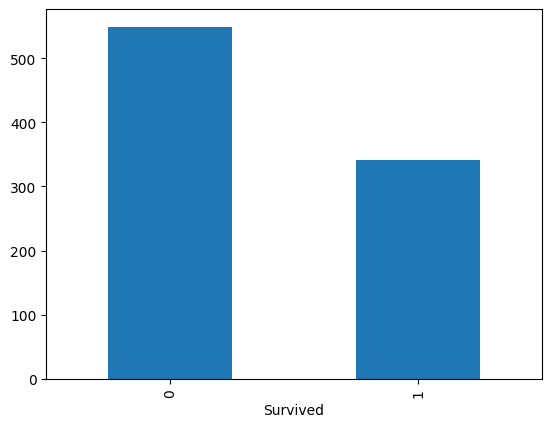

In [620]:
survived_ax = df["Survived"].value_counts().plot(kind="bar")

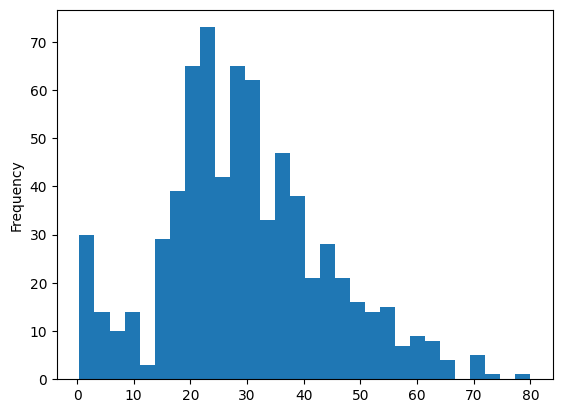

In [621]:
ages_ax = df["Age"].plot(kind="hist", bins=30)
# there are anomalies, median for filling NaN will be better

In [622]:
df["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

<Axes: xlabel='Age', ylabel='Count'>

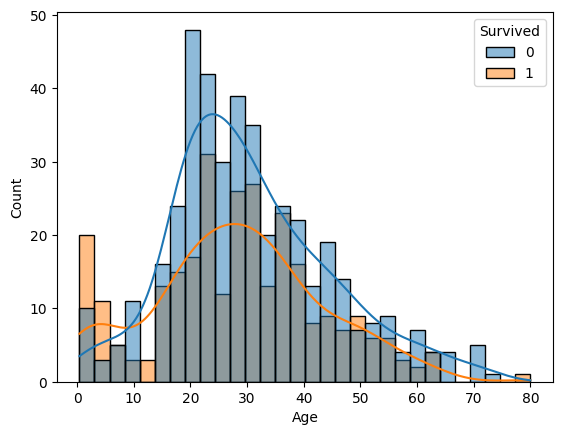

In [623]:
sns.histplot(data=df, x='Age', hue='Survived', bins=30, kde=True, alpha=0.5)

In [624]:
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
# filling NaN based on Pclass Sex 
# we need to fill it now to create new features and test hypoth.

In [625]:
# let's create new feature from Name (parse title from it)

df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
# let's have only Mrs, Miss, Mr and Master (4 most popular title)
title_mapping = {'Mlle': 'Miss', 
                 'Ms': 'Miss', 
                 'Mme': 'Mrs', 
                 'Major': "Mr",
                 'Dr': 'Mr',
                 'Lady': "Miss",
                 'Rev': "Mr",
                 'Col': 'Mr', 
                 'Don': 'Mr',
                 'Sir': 'Mr',
                 'Capt': 'Mr',
                 'Countess': 'Miss',
                 'Jonkheer': 'Mr' }
df['Title'] = df['Title'].replace(title_mapping)

df.groupby("Title")["Survived"].mean()
# As we can see women had more chanses to survive

Title
Master    0.575000
Miss      0.705882
Mr        0.161710
Mrs       0.793651
Name: Survived, dtype: float64

In [626]:
# let's create 

bins = [0.40, 7.5, 30, 50, 80.0]
labels = [4, 1, 3, 2]
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels).astype(int)
survival_by_age = df.groupby('age_group')['Survived'].mean()
df["age_group"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: age_group
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


<Axes: xlabel='age_group', ylabel='Age'>

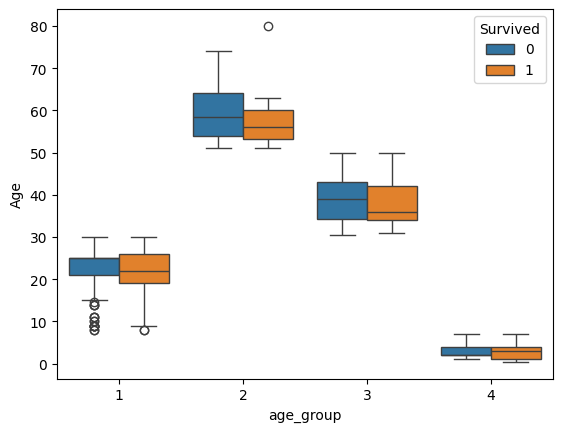

In [627]:
sns.boxplot(x='age_group', y='Age', hue='Survived', data=df)
# test hypothesis

In [628]:
df["age_group"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: age_group
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


In [629]:
df["IsChild"] = (df["age_group"] == "child").astype(int)
# one more new feature

<Axes: >

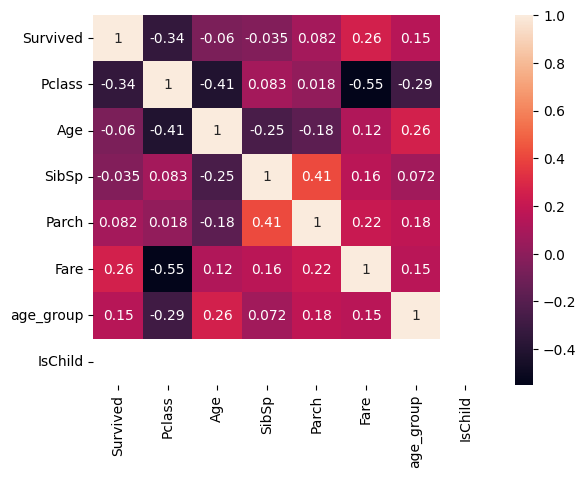

In [630]:
corr_data = df.corr(numeric_only = True)
sns.heatmap(corr_data, annot=True)

We see that
+ Pclass is super correlated with target
+ Fare is also correlated, but it is also thery correlated with Pclass, but not high
+ Age could also help us somehow

Let's take a look at the data again

In [631]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,age_group,IsChild
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,3,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,3,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,3,0


In [632]:
df.groupby('Sex')['Survived'].mean() # hihly correlated

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [633]:
df.groupby('Embarked')['Survived'].mean() # also can be interesting

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [634]:
df["Cabin"].isnull().sum() # too many lost values, but it's still could be helpful

np.int64(687)

In [635]:
df.groupby('SibSp')['Survived'].mean() # not very informative, need new feature

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [636]:
df["FamilySize"] = df['SibSp'] + df['Parch'] + 1 # create new feature
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,age_group,IsChild,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,0,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,3,0,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,3,0,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Mr,1,0,1
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,1,0,1
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.5,1,2,W./C. 6607,23.4500,NaN,S,Miss,1,0,4
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,1,0,1


In [637]:
df.groupby("FamilySize")["Survived"].mean() # may be used in our model

FamilySize
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

In [638]:
df["Cabin"] = df["Cabin"].str[0] # parse the deck (letter)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,age_group,IsChild,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,0,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,3,0,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs,3,0,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Mr,1,0,1
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S,Miss,1,0,1
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.5,1,2,W./C. 6607,23.4500,NaN,S,Miss,1,0,4
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,Mr,1,0,1


<Axes: xlabel='Cabin', ylabel='Count'>

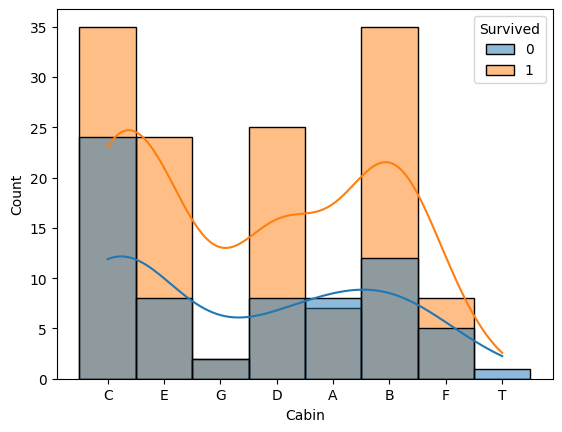

In [639]:
sns.histplot(data=df, x="Cabin", hue='Survived', kde=True, bins=30)

In [640]:
df = df.drop(columns=['Name', 'Ticket', 'SibSp', 'Parch'])
df

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,age_group,IsChild,FamilySize
0,0,3,male,22.0,7.2500,NaN,S,Mr,1,0,2
1,1,1,female,38.0,71.2833,C,C,Mrs,3,0,2
2,1,3,female,26.0,7.9250,NaN,S,Miss,1,0,1
3,1,1,female,35.0,53.1000,C,S,Mrs,3,0,2
4,0,3,male,35.0,8.0500,NaN,S,Mr,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,NaN,S,Mr,1,0,1
887,1,1,female,19.0,30.0000,B,S,Miss,1,0,1
888,0,3,female,21.5,23.4500,NaN,S,Miss,1,0,4
889,1,1,male,26.0,30.0000,C,C,Mr,1,0,1


<Axes: >

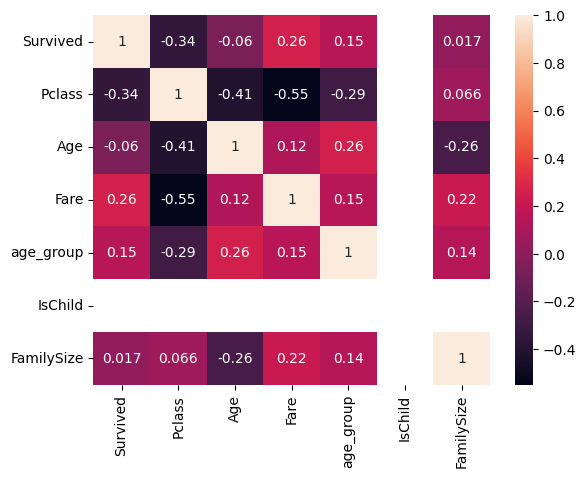

In [641]:
corr_data = df.corr(numeric_only = True)
sns.heatmap(corr_data, annot=True)

### Preprocessing data

In [642]:
X = df.drop(columns="Survived")
y = df["Survived"]

In [643]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Sex         891 non-null    object 
 2   Age         891 non-null    float64
 3   Fare        891 non-null    float64
 4   Cabin       204 non-null    object 
 5   Embarked    889 non-null    object 
 6   Title       891 non-null    object 
 7   age_group   891 non-null    int64  
 8   IsChild     891 non-null    int64  
 9   FamilySize  891 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [644]:
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Cabin       204 non-null    object 
 6   Embarked    889 non-null    object 
 7   Title       891 non-null    object 
 8   age_group   891 non-null    int64  
 9   IsChild     891 non-null    int64  
 10  FamilySize  891 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [645]:
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
df

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,age_group,IsChild,FamilySize,IsAlone
0,0,3,male,22.0,7.2500,NaN,S,Mr,1,0,2,0
1,1,1,female,38.0,71.2833,C,C,Mrs,3,0,2,0
2,1,3,female,26.0,7.9250,NaN,S,Miss,1,0,1,1
3,1,1,female,35.0,53.1000,C,S,Mrs,3,0,2,0
4,0,3,male,35.0,8.0500,NaN,S,Mr,3,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,NaN,S,Mr,1,0,1,1
887,1,1,female,19.0,30.0000,B,S,Miss,1,0,1,1
888,0,3,female,21.5,23.4500,NaN,S,Miss,1,0,4,0
889,1,1,male,26.0,30.0000,C,C,Mr,1,0,1,1


In [646]:
df["Embarked"].mode()

0    S
Name: Embarked, dtype: object

In [647]:
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Cabin       204 non-null    object 
 6   Embarked    891 non-null    object 
 7   Title       891 non-null    object 
 8   age_group   891 non-null    int64  
 9   IsChild     891 non-null    int64  
 10  FamilySize  891 non-null    int64  
 11  IsAlone     891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


In [648]:
df.head() # time to encode

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,age_group,IsChild,FamilySize,IsAlone
0,0,3,male,22.0,7.2500,NaN,S,Mr,1,0,2,0
1,1,1,female,38.0,71.2833,C,C,Mrs,3,0,2,0
2,1,3,female,26.0,7.9250,NaN,S,Miss,1,0,1,1
3,1,1,female,35.0,53.1000,C,S,Mrs,3,0,2,0
4,0,3,male,35.0,8.0500,NaN,S,Mr,3,0,1,1


In [649]:
df["Embarked"].value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [650]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)  
encoded_features = encoder.fit_transform(df[['Sex', 'Embarked', "Cabin"]])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Sex', 'Embarked', "Cabin"]))
df_encoded = pd.concat([df.drop(columns=['Sex', 'Embarked', "Cabin"]), encoded_df], axis=1)
df = df_encoded
# df['Fare_log'] = np.log1p(df['Fare'])
df = df.drop(columns=["Cabin_nan", "Title", "IsAlone", "IsChild"])
df

,Survived,Pclass,Age,Fare,age_group,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0,3,22.0,7.2500,1,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,38.0,71.2833,3,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,3,26.0,7.9250,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,35.0,53.1000,3,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,3,35.0,8.0500,3,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,13.0000,1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,1,1,19.0,30.0000,1,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0,3,21.5,23.4500,1,4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,1,1,26.0,30.0000,1,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [651]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# df[['Age', 'Fare_log', 'FamilySize']] = scaler.fit_transform(df[['Age', 'Fare_log', 'FamilySize']])

### Models selections and training
1) divide into train and test
2) train models
3) compare results

In [652]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop(columns=["Survived"])
y = df["Survived"]

# we need (almost) same distributions in our sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_indecies, test_indecies in split.split(X, y):
    X_train, y_train = X.iloc[train_indecies], y.iloc[train_indecies]
    X_test, y_test = X.iloc[test_indecies], y.iloc[test_indecies]
    
print("Train distribution: ")
print(y_train.value_counts(normalize=True))
print("\n")
print("Test distribution: ")
print(y_test.value_counts(normalize=True))

Train distribution: 
Survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64


Test distribution: 
Survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


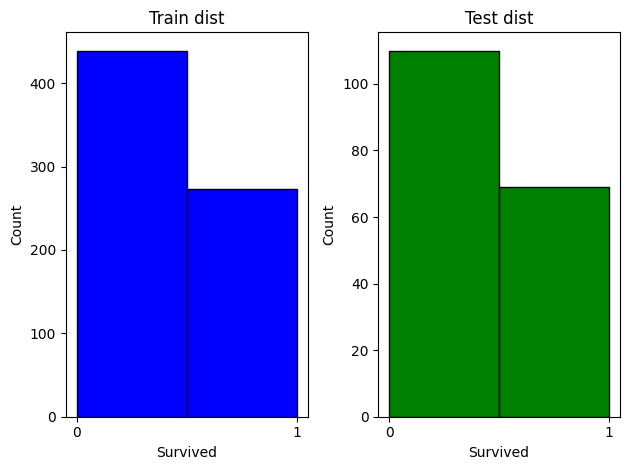

In [653]:
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=2, edgecolor='black', color='blue')
plt.title('Train dist')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks([0, 1])

plt.subplot(1, 2, 2)
plt.hist(y_test, bins=2, edgecolor='black', color='green')
plt.title('Test dist')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks([0, 1])

plt.tight_layout()
plt.show()

**Logistic regression**

In [654]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred_logreg = log_reg.predict(X_test)

log_reg_acc = accuracy_score(y_test, y_pred_logreg)
print("Logistic Regression Accuracy:", log_reg_acc)
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.68      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



c:\Users\Skulakova\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Decision Tree**

In [655]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
tree_acc = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Accuracy:", tree_acc)
print(classification_report(y_test, y_pred_tree))

Decision Tree Accuracy: 0.7877094972067039
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       110
           1       0.72      0.72      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



**Random Forest**

In [656]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_test)
forest_acc = accuracy_score(y_test, y_pred_forest)
print("Random Forest Accuracy: ", forest_acc)
print(classification_report(y_test, y_pred_forest))

Random Forest Accuracy:  0.8379888268156425
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       110
           1       0.82      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



**kNN**

In [657]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

knn_acc = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", knn_acc)
print(classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.7094972067039106
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       110
           1       0.67      0.48      0.56        69

    accuracy                           0.71       179
   macro avg       0.70      0.67      0.67       179
weighted avg       0.70      0.71      0.70       179



**Gradient Boosting**

In [658]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)  
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
gb_acc = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", gb_acc)
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.8603351955307262
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       110
           1       0.87      0.75      0.81        69

    accuracy                           0.86       179
   macro avg       0.86      0.84      0.85       179
weighted avg       0.86      0.86      0.86       179



In [659]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest',
              'Gradient Boosting', 
              'Decision Tree'],
    'Score': [knn_acc, log_reg_acc,
              forest_acc, gb_acc, tree_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Gradient Boosting,0.860335
2,Random Forest,0.837989
1,Logistic Regression,0.798883
4,Decision Tree,0.787709
0,KNN,0.709497


### Submission

In [660]:
df.head()

,Survived,Pclass,Age,Fare,age_group,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0,3,22.0,7.2500,1,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,38.0,71.2833,3,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,3,26.0,7.9250,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,35.0,53.1000,3,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,3,35.0,8.0500,3,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [661]:
data = pd.read_csv("../data/test.csv", index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [662]:
data['Age'] = data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])
data["Fare"] = data["Fare"].fillna(data["Fare"].median())

# bins = [0.42, 7.5, 20, 50, 80.0]
# labels = ["child", "young", "adult", "old"]
# data['age_group'] = pd.cut(data['Age'], bins=bins, labels=labels)
bins = [0.0, 7.5, 30, 50, 80.0]
labels = [4, 1, 3, 2]
data['age_group'] = pd.cut(data['Age'], bins=bins, labels=labels).astype(int)
# data["IsChild"] = (data["age_group"] == 4).astype(int)

data["FamilySize"] = data['SibSp'] + data['Parch'] + 1
# data["IsAlone"] = (data["FamilySize"] == 1).astype(int)
data["Cabin"] = data["Cabin"].str[0]

data = data.drop(columns=['Name', 'Ticket', 'SibSp', 'Parch'])

encoded_features = encoder.transform(data[['Sex', 'Embarked', "Cabin"]])
test_encoded_data = pd.DataFrame(encoded_features, 
                               columns=encoder.get_feature_names_out(['Sex', 'Embarked', "Cabin"]),
                               index=data.index) 


data = pd.concat([data.drop(columns=['Sex', 'Embarked', "Cabin"]), test_encoded_data], axis=1)
data = data.drop(columns=["Cabin_nan"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   Fare        418 non-null    float64
 3   age_group   418 non-null    int64  
 4   FamilySize  418 non-null    int64  
 5   Sex_female  418 non-null    float64
 6   Sex_male    418 non-null    float64
 7   Embarked_C  418 non-null    float64
 8   Embarked_Q  418 non-null    float64
 9   Embarked_S  418 non-null    float64
 10  Cabin_A     418 non-null    float64
 11  Cabin_B     418 non-null    float64
 12  Cabin_C     418 non-null    float64
 13  Cabin_D     418 non-null    float64
 14  Cabin_E     418 non-null    float64
 15  Cabin_F     418 non-null    float64
 16  Cabin_G     418 non-null    float64
 17  Cabin_T     418 non-null    float64
dtypes: float64(15), int64(3)
memory usage: 62.0 KB


In [663]:
test_y_pred = gb.predict(data)

In [664]:
data.reset_index(inplace=True)
submission = pd.DataFrame({
        "PassengerId": data["PassengerId"],
        "Survived": test_y_pred
    })
submission.to_csv('../output/submission_gb.csv', index=False)